# Named Entity Recognition
Mateusz Wojtulewicz

In [1]:
from xml.etree import ElementTree as ET
from pathlib import Path
from collections import Counter

### 1. Read the classification of [Named Entities](https://clarin-pl.eu/dspace/bitstream/handle/11321/294/WytyczneKPWr-jednostkiidentyfikacyjne.pdf).


### 2. Read the [API of NER](https://wiki.clarin-pl.eu/pl/nlpws/services/liner2) in [Clarin](https://ws.clarin-pl.eu/ner.shtml).

### 3. Read the [documentation of CCL format](https://wiki.clarin-pl.eu/pl/nlpws/services/ccl) or [more tourough documentation of CCL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).

### 4. Sort bills according to their size and take top 50 (largest) bills.

In [16]:
acts_dir = Path("../data/ustawy/")

acts_stats = ((act.name, act.stat().st_size) for act in acts_dir.iterdir())
acts_stats = sorted(acts_stats, key=lambda x: x[1], reverse=True)
acts_stats[:10]

[('2000_696.txt', 579582),
 ('1996_465.txt', 420981),
 ('2001_627.txt', 413929),
 ('1997_555.txt', 396494),
 ('2002_1689.txt', 352618),
 ('2000_1186.txt', 275546),
 ('1998_1118.txt', 271036),
 ('1997_117.txt', 262973),
 ('2001_1070.txt', 259359),
 ('2001_1368.txt', 258344)]

In [17]:
acts_longest = [path for path, size in acts_stats[:50]]

### 5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence.

In [18]:
clarin_acts_dir = Path("../data/ustawy_tagged_clarin_morf1/")

acts_longest_clarin = [clarin_acts_dir / act for act in acts_longest]
len(acts_longest_clarin)

50

In [19]:
acts_entities = {}

for act in acts_longest_clarin:
    
    act_id = act.stem
    content = act.read_text(encoding="utf8")
    tree = ET.fromstring(text=content)
    
    entities = []
    for sentence in tree.iter("sentence"):
        tokens = list(sentence.iter("tok"))[1:]
        entity_parts = []
        for token in tokens:
            orth = token.find("orth")
            if orth.text[0].isupper():
                base = token.find("lex").find("base").text.capitalize()
                entity_parts.append(base)
            elif len(entity_parts) > 0:
                entity = " ".join(entity_parts)
                entities.append(entity)
                entity_parts = []
    
    acts_entities[act_id] = entities

### 6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [21]:
entities_all = [entity for entities in acts_entities.values() for entity in entities]
entities_counter = Counter(entities_all)
entities_counter.most_common(50)

[('Nr', 4585),
 ('Dziennik', 1601),
 ('U', 1543),
 ('Art', 1191),
 ('Rzeczpospolita Polski', 751),
 ('Kodeks', 509),
 ('Policja', 464),
 ('Skarb Państwo', 395),
 ('Prawo', 330),
 ('Kasa Chory', 321),
 ('Unia Europejski', 292),
 ('Straż Graniczny', 290),
 ('Minister', 276),
 ('Rada Minister', 274),
 ('Państwowy Straż Pożarny', 239),
 ('Zakład', 230),
 ('Państwowy Komisja Wyborczy', 211),
 ('Rada', 190),
 ('Pozostały', 185),
 ('Fundusz', 183),
 ('Prezes Urząd', 183),
 ('I', 181),
 ('Zmiana', 175),
 ('Minister Obrona Narodowy', 174),
 ('Minister Sprawiedliwość', 172),
 ('Urząd Patentowy', 172),
 ('Sprawiedliwość', 164),
 ('Azot', 160),
 ('Ii', 150),
 ('Urząd Ochrona Państwo', 141),
 ('Tkanina', 138),
 ('Prezes Rada Minister', 134),
 ('Obrona Narodowy', 129),
 ('Minister Finanse', 127),
 ('Finanse', 116),
 ('Iii', 115),
 ('Inspektor Nadzór Wewnętrzny', 115),
 ('Efta', 114),
 ('P2o5', 110),
 ('Biuro', 109),
 ('Komisja', 107),
 ('Nawóz', 107),
 ('Administracja', 106),
 ('Europejski Obszar Go

### 7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the `n82` model.

Firstly, I copied 50 longest acts to a separate directory. Then I zipped it and put into Clarin `n82` model. At the end I saved the results and unpacked them.

In [29]:
import shutil

In [33]:
acts_longest_dir = Path("../data/ustawy_longest/")
acts_longest_dir.mkdir(parents=True, exist_ok=True)

for act_path in acts_longest:
    shutil.copy(
        src=acts_dir / act_path,
        dst=acts_longest_dir / act_path
    )

In [38]:
acts_n82_dir = Path("../data/ustawy_entities_n82/")

acts_entities_n82 = {}

for act in acts_n82_dir.iterdir():
    
    act_id = act.stem
    content = act.read_text(encoding="utf8")
    tree = ET.fromstring(text=content)
    
    entities = []
    
    for sentence in tree.iter("sentence"):
        
        sentence_id = sentence.attrib["id"]
        tokens = sentence.iter("tok")

        # for every annotation class store list of bases and orths
        bases = {}
        orths = {}
        
        for token in tokens:
            
            orth = token.find("orth")
            base = token.find("lex").find("base")
            
            anns = token.iter("ann")
            
            for ann in anns:
                # zero values mean that token is not part of given enetity type
                if ann.text == "0":
                    continue
                
                # type and instance id
                type_and_id = f"{ann.attrib['chan']}:{ann.text}"
                
                # initialize empty lists if new type
                if not type_and_id in bases.keys():
                    bases[type_and_id] = []
                    orths[type_and_id] = []
                
                bases[type_and_id].append(base.text.lower())
                orths[type_and_id].append(orth.text)
            
        # construct entities tuples: (bases, orths, type, sentence_id)
        for type_and_id in bases.keys():
            e_bases = " ".join(bases[type_and_id])
            e_orths = " ".join(orths[type_and_id])
            e_type = type_and_id.split(":")[0]
            entity_tuple = e_bases, e_orths, e_type, sentence_id
            entities.append(entity_tuple)
        
    acts_entities_n82[act_id] = entities

Examplary output:

In [39]:
acts_entities_n82["ustawy_longest%1994_195"][:5]

[('urząd patentowy rzeczpospolita polski',
  'Urzędu Patentowego Rzeczypospolitej Polskiej',
  'nam_org_institution',
  's6'),
 ('urząd patentowy', 'Urzędem Patentowym', 'nam_org_institution', 's6'),
 ('rzeczpospolita polski',
  'Rzeczypospolitej Polskiej',
  'nam_loc_gpe_country',
  's13'),
 ('rzeczpospolita polska',
  'Rzeczpospolita Polska',
  'nam_loc_gpe_country',
  's13'),
 ('konwencja paryski', 'Konwencję paryską', 'nam_pro_title_document', 's13')]

### 8. Plot the frequency (histogram) of the coarse-grained classes (e.g. `nam_adj`, `nam_eve`, `nam_fac`).

In [55]:
import matplotlib.pyplot as plt

In [42]:
def get_ctype(entity_tuple: tuple) -> str:
    e_type = entity_tuple[2]
    ctype = "_".join(e_type.split("_")[:2])
    return ctype

In [43]:
entities_n82_all = [entity for entities in acts_entities_n82.values() for entity in entities]
ctypes_all = [get_ctype(entity_tuple) for entity_tuple in entities_n82_all]
ctypes_counter = Counter(ctypes_all)

In [71]:
ctypes_sorted = ctypes_counter.most_common()
ctypes_sorted

[('nam_org', 9751),
 ('nam_pro', 3191),
 ('nam_loc', 1537),
 ('nam_liv', 652),
 ('nam_oth', 557),
 ('nam_adj', 383),
 ('nam_fac', 147),
 ('nam_eve', 30),
 ('nam_num', 14)]

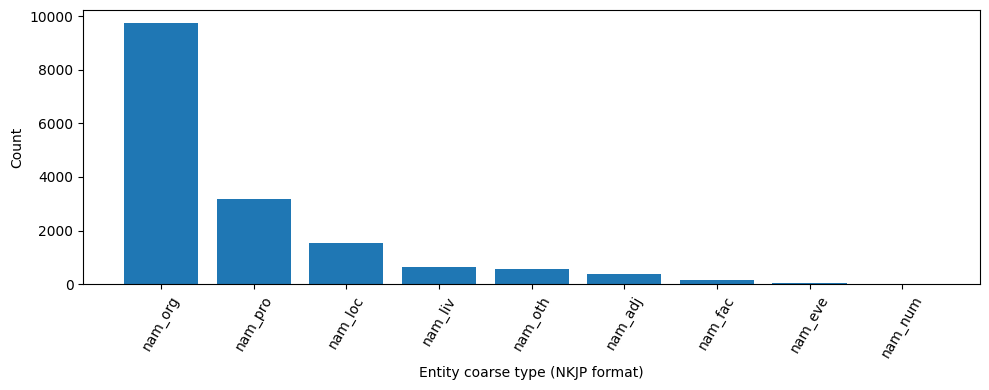

In [ ]:
ctype_names = [ctype for ctype, count in ctypes_sorted] 
ctype_count = [count for ctype, count in ctypes_sorted] 

plt.figure(figsize=(10, 4))
plt.bar(ctype_names, ctype_count)
plt.xlabel("Entity coarse type (NKJP format)")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### 9. Display 10 most frequent Named Entities for each coarse-grained type.

In [78]:
for ctype in ctypes_counter.keys():
    print(f"\n--- {ctype.upper()} ---")
    
    entities_filtered = [entity[0] for entity in entities_n82_all if get_ctype(entity) == ctype]
    ef_counter = Counter(entities_filtered)
    for entity, count in ef_counter.most_common(10):
        print(f"{entity} [{count}]")


--- NAM_ORG ---
skarb państwo [410]
minister sprawiedliwość [322]
unia europejski [297]
minister obrona narodowy [287]
rada minister [279]
państwowy komisja wyborczy [268]
prezes rad minister [264]
państwowy straż pożarny [259]
minister finanse [234]
prezes urząd [201]

--- NAM_LOC ---
rzeczpospolita polski [815]
rzeczpospolita polska [95]
polska [72]
warszawa [71]
nawóz [28]
konfederacja szwajcarski [14]
rejestr [8]
londyn [7]
mazowiecki [7]
zakład [6]

--- NAM_PRO ---
dzieje_(apostolskie) . u . [1097]
dziennik . u . [438]
dziennik . urz [80]
ordynacja podatkowy [78]
kodeks karny [68]
monitor polska [62]
sprawa wewnętrzny [51]
kodeks postępowanie cywilny [41]
kodeks postępowanie administracyjny [40]
kodeks postępowanie karny [36]

--- NAM_ADJ ---
polski [204]
wojewódzki [20]
europejski [15]
mazowiecki [7]
internetowy [5]
macierzyński [3]
warszawski [3]
afrykański [2]
lubiński [2]
wrocławski [2]

--- NAM_LIV ---
kasa chora [109]
pan [40]
straż graniczny [36]
krajowy depozyt [25]
siła 

### 10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [81]:
entities_n82_bases_all = [(entity[0], entity[2]) for entity in entities_n82_all]

Counter(entities_n82_bases_all).most_common(50)

[(('dzieje_(apostolskie) . u .', 'nam_pro_media_periodic'), 1097),
 (('rzeczpospolita polski', 'nam_loc_gpe_country'), 815),
 (('dziennik . u .', 'nam_pro_media_periodic'), 438),
 (('skarb państwo', 'nam_org_institution'), 410),
 (('złoty', 'nam_oth_currency'), 334),
 (('minister sprawiedliwość', 'nam_org_institution'), 322),
 (('unia europejski', 'nam_org_organization'), 296),
 (('minister obrona narodowy', 'nam_org_institution'), 287),
 (('rada minister', 'nam_org_institution'), 279),
 (('państwowy komisja wyborczy', 'nam_org_institution'), 267),
 (('prezes rad minister', 'nam_org_institution'), 264),
 (('minister finanse', 'nam_org_institution'), 234),
 (('państwowy straż pożarny', 'nam_org_organization'), 225),
 (('polski', 'nam_adj_country'), 204),
 (('prezes urząd', 'nam_org_institution'), 201),
 (('urząd patentowy', 'nam_org_institution'), 196),
 (('urząd ochrona państwo', 'nam_org_institution'), 181),
 (('euro', 'nam_oth_currency'), 118),
 (('sąd najwyższy', 'nam_org_institutio

### 11. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.

In [83]:
sentences_2ners = []

for act_id, entities in acts_entities_n82.items():
    act_sentences = {}
    
    for entity in entities:
        e_base, e_orth, e_type, s_id = entity
        if s_id not in act_sentences.keys():
            act_sentences[s_id] = set()
        act_sentences[s_id].add(e_type)
    
    for s_id, types_set in act_sentences.items():
        if len(types_set) >= 2:
            sentences_2ners.append((act_id, s_id))

In [94]:
def find_and_parse_sentence(act_id: str, s_id: str):
    act = acts_n82_dir / f"{act_id}.txt"
    content = act.read_text(encoding="utf8")
    tree = ET.fromstring(text=content)
    
    tokens = []
    for sentence in tree.iter("sentence"):
        if sentence.attrib["id"] == s_id:
            tokens = [token.find("orth").text for token in sentence.iter("tok")]
    
    entities = []
    for entity in acts_entities_n82[act_id]:
        e_base, e_orth, e_type, sentence_id = entity
        if sentence_id == s_id:
            entities.append((e_orth, e_type))
    
    return tokens, entities 

In [82]:
import spacy
from spacy import displacy

In [100]:
# blank language model
nlp = spacy.blank("pl")

def highlight_sentence(tokens, entities):
    sentence = " ".join(tokens)
    doc = nlp.make_doc(sentence)
    ents = []
    for entity in entities:
        e_orth, e_type = entity
        start = sentence.index(e_orth)
        stop = start + len(e_orth)
        ents.append(doc.char_span(start, stop, label=e_type))
    
    doc.ents = ents
    displacy.render(doc, style="ent", jupyter=True)
        

In [101]:
import random

for act_id, s_id in random.sample(sentences_2ners, 5):
    tokens, entities = find_and_parse_sentence(act_id=act_id, s_id=s_id)
    highlight_sentence(tokens=tokens, entities=entities)

### 12. Answer the following questions:

#### a. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

The NER method worked much better, because it could capture a name which parts are not only capitalized words, e.g. `ustawy z dnia 26 lipca 1991 r . o podatku dochodowym od osób fizycznych`.

#### b. What are the drawbacks of the method based on capital letters?

As mentioned above, it lacked the ability to classify longer, not capitalized word sequences as NERs. ALso, there were many false positive NERs, mainly units or abbreviations, such as `Nr`, `III`.

#### c. What are the drawbacks of the method based on NER?

The most obvious drawback is that before using a model it must be trained to be able to capture entities correctly.

#### d. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

In my opinion, the best results has the `nam_org` group, which might be because it is the most common in the corpus. The worst results can be observed for `nam_num` group, as it is very strange to classify a number as a Named Entity on its own rather than with an entity that is being numbered.

#### e. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

I think that NER alone is not sufficient for such a task. A word2vec embedding might be a usefull tool to find similar NER entities.

#### f. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

A problem requiring looking for keywords in a conversation might use NER algorithm as one way of extracting keywords.